In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 14 # the number of class
        self.feat_d = 120
        self.filters = 32
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/JHMDB/'
C = Config()

In [4]:
from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,0,C.joint_n)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],p[f],'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    return p

def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        p = normlize_range(p)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=15,joint_d=2,feat_d=120,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.05)(x)
    x = c1D(x,filters,3)
    x = block(x,filters)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.05)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.05)(x_d_slow)
    x_d_slow = block(x_d_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.05)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.05)(x_d_fast)
    x_d_fast = block(x_d_fast,filters) 
    x_d_fast = SpatialDropout1D(0.05)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.2)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_AR_single(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
AR_single = build_AR_single(C)
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 120)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 256)       446848      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 256)          0           model_1[1][0]                    
__________

## Train and test on GT_split 1

In [150]:
Train = pickle.load(open(C.data_dir+"GT_train_1.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_1.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 176/176 [00:00<00:00, 504.09it/s]


In [154]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=500,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 433 samples, validate on 176 samples
Epoch 1/500
433/433 [==============================] - 20s 46ms/step - loss: 3.4230 - acc: 0.0670 - val_loss: 2.6010 - val_acc: 0.1136
Epoch 2/500
433/433 [==============================] - 0s 180us/step - loss: 3.2400 - acc: 0.0878 - val_loss: 2.4612 - val_acc: 0.2386
Epoch 3/500
433/433 [==============================] - 0s 166us/step - loss: 2.9833 - acc: 0.1039 - val_loss: 2.3748 - val_acc: 0.2273
Epoch 4/500
433/433 [==============================] - 0s 194us/step - loss: 2.7495 - acc: 0.1570 - val_loss: 2.3160 - val_acc: 0.2841
Epoch 5/500
433/433 [==============================] - 0s 192us/step - loss: 2.7036 - acc: 0.1686 - val_loss: 2.2709 - val_acc: 0.3068
Epoch 6/500
433/433 [==============================] - 0s 204us/step - loss: 2.5432 - acc: 0.1894 - val_loss: 2.2313 - val_acc: 0.2898
Epoch 7/500
433/433 [==============================] - 0s 199us/step - loss: 2.4439 - acc: 0.2309 - val_loss: 2.1809 - val_acc: 0.3011
Epoch 8/5

Epoch 61/500
433/433 [==============================] - 0s 214us/step - loss: 0.4299 - acc: 0.8938 - val_loss: 1.1187 - val_acc: 0.6534
Epoch 62/500
433/433 [==============================] - 0s 173us/step - loss: 0.3927 - acc: 0.8915 - val_loss: 1.1476 - val_acc: 0.6477
Epoch 63/500
433/433 [==============================] - 0s 205us/step - loss: 0.3685 - acc: 0.9145 - val_loss: 1.1875 - val_acc: 0.6477
Epoch 64/500
433/433 [==============================] - 0s 185us/step - loss: 0.3366 - acc: 0.9192 - val_loss: 1.2056 - val_acc: 0.6364
Epoch 65/500
433/433 [==============================] - 0s 190us/step - loss: 0.3677 - acc: 0.9122 - val_loss: 1.2008 - val_acc: 0.6477
Epoch 66/500
433/433 [==============================] - 0s 218us/step - loss: 0.3578 - acc: 0.9215 - val_loss: 1.1803 - val_acc: 0.6591
Epoch 67/500
433/433 [==============================] - 0s 199us/step - loss: 0.3217 - acc: 0.9099 - val_loss: 1.1688 - val_acc: 0.6591
Epoch 68/500
433/433 [==========================

433/433 [==============================] - 0s 177us/step - loss: 0.1158 - acc: 0.9792 - val_loss: 1.0550 - val_acc: 0.6989
Epoch 122/500
433/433 [==============================] - 0s 200us/step - loss: 0.1138 - acc: 0.9908 - val_loss: 1.0473 - val_acc: 0.6989
Epoch 123/500
433/433 [==============================] - 0s 208us/step - loss: 0.1025 - acc: 0.9885 - val_loss: 1.0397 - val_acc: 0.6989
Epoch 124/500
433/433 [==============================] - 0s 205us/step - loss: 0.1059 - acc: 0.9792 - val_loss: 1.0321 - val_acc: 0.6989
Epoch 125/500
433/433 [==============================] - 0s 201us/step - loss: 0.0878 - acc: 0.9954 - val_loss: 1.0273 - val_acc: 0.7102
Epoch 126/500
433/433 [==============================] - 0s 208us/step - loss: 0.0986 - acc: 0.9885 - val_loss: 1.0208 - val_acc: 0.7216
Epoch 127/500
433/433 [==============================] - 0s 216us/step - loss: 0.1071 - acc: 0.9908 - val_loss: 1.0161 - val_acc: 0.7273
Epoch 128/500
433/433 [==============================] 

Epoch 181/500
433/433 [==============================] - 0s 209us/step - loss: 0.0916 - acc: 0.9954 - val_loss: 0.8656 - val_acc: 0.7670
Epoch 182/500
433/433 [==============================] - 0s 225us/step - loss: 0.0914 - acc: 0.9931 - val_loss: 0.8640 - val_acc: 0.7670
Epoch 183/500
433/433 [==============================] - 0s 213us/step - loss: 0.0827 - acc: 0.9954 - val_loss: 0.8626 - val_acc: 0.7670
Epoch 184/500
433/433 [==============================] - 0s 200us/step - loss: 0.0948 - acc: 0.9861 - val_loss: 0.8609 - val_acc: 0.7670
Epoch 185/500
433/433 [==============================] - 0s 200us/step - loss: 0.0915 - acc: 0.9861 - val_loss: 0.8595 - val_acc: 0.7727
Epoch 186/500
433/433 [==============================] - 0s 221us/step - loss: 0.1016 - acc: 0.9954 - val_loss: 0.8582 - val_acc: 0.7727
Epoch 187/500
433/433 [==============================] - 0s 205us/step - loss: 0.1018 - acc: 0.9885 - val_loss: 0.8567 - val_acc: 0.7784
Epoch 188/500
433/433 [==================

Epoch 241/500
433/433 [==============================] - 0s 181us/step - loss: 0.0896 - acc: 0.9931 - val_loss: 0.8140 - val_acc: 0.7784
Epoch 242/500
433/433 [==============================] - 0s 209us/step - loss: 0.1012 - acc: 0.9861 - val_loss: 0.8136 - val_acc: 0.7784
Epoch 243/500
433/433 [==============================] - 0s 215us/step - loss: 0.1282 - acc: 0.9792 - val_loss: 0.8132 - val_acc: 0.7784
Epoch 244/500
433/433 [==============================] - 0s 213us/step - loss: 0.1029 - acc: 0.9908 - val_loss: 0.8129 - val_acc: 0.7784
Epoch 245/500
433/433 [==============================] - 0s 198us/step - loss: 0.0843 - acc: 0.9885 - val_loss: 0.8125 - val_acc: 0.7784
Epoch 246/500
433/433 [==============================] - 0s 199us/step - loss: 0.1108 - acc: 0.9861 - val_loss: 0.8122 - val_acc: 0.7784
Epoch 247/500
433/433 [==============================] - 0s 211us/step - loss: 0.0918 - acc: 0.9931 - val_loss: 0.8120 - val_acc: 0.7784
Epoch 248/500
433/433 [==================

Epoch 301/500
433/433 [==============================] - 0s 212us/step - loss: 0.0786 - acc: 0.9931 - val_loss: 0.7947 - val_acc: 0.7727
Epoch 302/500
433/433 [==============================] - 0s 217us/step - loss: 0.0842 - acc: 0.9954 - val_loss: 0.7945 - val_acc: 0.7727
Epoch 303/500
433/433 [==============================] - 0s 212us/step - loss: 0.0880 - acc: 0.9885 - val_loss: 0.7942 - val_acc: 0.7670
Epoch 304/500
433/433 [==============================] - 0s 189us/step - loss: 0.0874 - acc: 0.9908 - val_loss: 0.7940 - val_acc: 0.7670
Epoch 305/500
433/433 [==============================] - 0s 196us/step - loss: 0.1062 - acc: 0.9861 - val_loss: 0.7940 - val_acc: 0.7670
Epoch 306/500
433/433 [==============================] - 0s 198us/step - loss: 0.0801 - acc: 0.9931 - val_loss: 0.7940 - val_acc: 0.7670
Epoch 307/500
433/433 [==============================] - 0s 209us/step - loss: 0.0996 - acc: 0.9885 - val_loss: 0.7937 - val_acc: 0.7670
Epoch 308/500
433/433 [==================

Epoch 361/500
433/433 [==============================] - 0s 209us/step - loss: 0.0884 - acc: 0.9885 - val_loss: 0.7782 - val_acc: 0.7727
Epoch 362/500
433/433 [==============================] - 0s 170us/step - loss: 0.0989 - acc: 0.9885 - val_loss: 0.7781 - val_acc: 0.7727
Epoch 363/500
433/433 [==============================] - 0s 196us/step - loss: 0.0998 - acc: 0.9908 - val_loss: 0.7781 - val_acc: 0.7727
Epoch 364/500
433/433 [==============================] - 0s 168us/step - loss: 0.0912 - acc: 0.9931 - val_loss: 0.7780 - val_acc: 0.7727
Epoch 365/500
433/433 [==============================] - 0s 198us/step - loss: 0.1001 - acc: 0.9838 - val_loss: 0.7780 - val_acc: 0.7727
Epoch 366/500
433/433 [==============================] - 0s 190us/step - loss: 0.0879 - acc: 0.9931 - val_loss: 0.7776 - val_acc: 0.7727
Epoch 367/500
433/433 [==============================] - 0s 194us/step - loss: 0.0808 - acc: 0.9954 - val_loss: 0.7773 - val_acc: 0.7727
Epoch 368/500
433/433 [==================

Epoch 421/500
433/433 [==============================] - 0s 209us/step - loss: 0.0807 - acc: 0.9931 - val_loss: 0.7725 - val_acc: 0.7784
Epoch 422/500
433/433 [==============================] - 0s 171us/step - loss: 0.0775 - acc: 0.9954 - val_loss: 0.7725 - val_acc: 0.7784
Epoch 423/500
433/433 [==============================] - 0s 187us/step - loss: 0.0820 - acc: 1.0000 - val_loss: 0.7726 - val_acc: 0.7784
Epoch 424/500
433/433 [==============================] - 0s 196us/step - loss: 0.0870 - acc: 0.9931 - val_loss: 0.7725 - val_acc: 0.7784
Epoch 425/500
433/433 [==============================] - 0s 190us/step - loss: 0.0926 - acc: 0.9861 - val_loss: 0.7728 - val_acc: 0.7784
Epoch 426/500
433/433 [==============================] - 0s 178us/step - loss: 0.0996 - acc: 0.9861 - val_loss: 0.7728 - val_acc: 0.7784
Epoch 427/500
433/433 [==============================] - 0s 190us/step - loss: 0.0800 - acc: 0.9908 - val_loss: 0.7728 - val_acc: 0.7784
Epoch 428/500
433/433 [==================

Epoch 481/500
433/433 [==============================] - 0s 212us/step - loss: 0.0987 - acc: 0.9861 - val_loss: 0.7773 - val_acc: 0.7784
Epoch 482/500
433/433 [==============================] - 0s 212us/step - loss: 0.0975 - acc: 0.9838 - val_loss: 0.7771 - val_acc: 0.7784
Epoch 483/500
433/433 [==============================] - 0s 208us/step - loss: 0.0835 - acc: 0.9908 - val_loss: 0.7769 - val_acc: 0.7784
Epoch 484/500
433/433 [==============================] - 0s 203us/step - loss: 0.0828 - acc: 0.9931 - val_loss: 0.7769 - val_acc: 0.7784
Epoch 485/500
433/433 [==============================] - 0s 206us/step - loss: 0.0952 - acc: 0.9908 - val_loss: 0.7768 - val_acc: 0.7784
Epoch 486/500
433/433 [==============================] - 0s 206us/step - loss: 0.0798 - acc: 0.9908 - val_loss: 0.7766 - val_acc: 0.7784
Epoch 487/500
433/433 [==============================] - 0s 193us/step - loss: 0.0735 - acc: 0.9931 - val_loss: 0.7765 - val_acc: 0.7784
Epoch 488/500
433/433 [==================

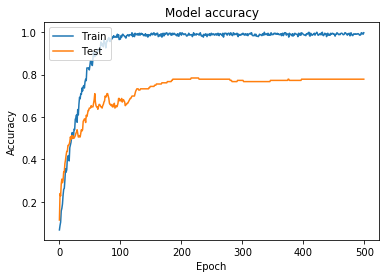

In [155]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 2

In [7]:
Train = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 176/176 [00:00<00:00, 475.34it/s]


In [8]:
# Re-initialize weights, since training and testing data switch
AR_single = build_AR_single(C)

In [9]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=500,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 433 samples, validate on 176 samples
Epoch 1/500
433/433 [==============================] - 9s 20ms/step - loss: 3.1962 - acc: 0.0970 - val_loss: 2.5320 - val_acc: 0.1761
Epoch 2/500
433/433 [==============================] - 0s 130us/step - loss: 3.0674 - acc: 0.0970 - val_loss: 2.4504 - val_acc: 0.2045
Epoch 3/500
433/433 [==============================] - 0s 134us/step - loss: 2.8091 - acc: 0.1339 - val_loss: 2.4129 - val_acc: 0.2273
Epoch 4/500
433/433 [==============================] - 0s 126us/step - loss: 2.7801 - acc: 0.1570 - val_loss: 2.4603 - val_acc: 0.2045
Epoch 5/500
433/433 [==============================] - 0s 113us/step - loss: 2.5066 - acc: 0.1824 - val_loss: 2.4974 - val_acc: 0.2216
Epoch 6/500
433/433 [==============================] - 0s 113us/step - loss: 2.5153 - acc: 0.2009 - val_loss: 2.4947 - val_acc: 0.2273
Epoch 7/500
433/433 [==============================] - 0s 110us/step - loss: 2.4311 - acc: 0.2263 - val_loss: 2.4281 - val_acc: 0.2727
Epoch 8/50

Epoch 61/500
433/433 [==============================] - 0s 116us/step - loss: 0.4348 - acc: 0.8915 - val_loss: 1.7107 - val_acc: 0.5114
Epoch 62/500
433/433 [==============================] - 0s 110us/step - loss: 0.4083 - acc: 0.9076 - val_loss: 1.6856 - val_acc: 0.5227
Epoch 63/500
433/433 [==============================] - 0s 103us/step - loss: 0.3394 - acc: 0.9261 - val_loss: 1.6562 - val_acc: 0.5398
Epoch 64/500
433/433 [==============================] - 0s 100us/step - loss: 0.3387 - acc: 0.9353 - val_loss: 1.6345 - val_acc: 0.5284
Epoch 65/500
433/433 [==============================] - 0s 100us/step - loss: 0.3400 - acc: 0.9307 - val_loss: 1.6259 - val_acc: 0.5227
Epoch 66/500
433/433 [==============================] - 0s 98us/step - loss: 0.3628 - acc: 0.9007 - val_loss: 1.6662 - val_acc: 0.5284
Epoch 67/500
433/433 [==============================] - 0s 124us/step - loss: 0.3021 - acc: 0.9353 - val_loss: 1.7196 - val_acc: 0.5455
Epoch 68/500
433/433 [===========================

Epoch 122/500
433/433 [==============================] - 0s 106us/step - loss: 0.0958 - acc: 0.9861 - val_loss: 1.2501 - val_acc: 0.6818
Epoch 123/500
433/433 [==============================] - 0s 107us/step - loss: 0.1294 - acc: 0.9838 - val_loss: 1.2461 - val_acc: 0.6818
Epoch 124/500
433/433 [==============================] - 0s 102us/step - loss: 0.1112 - acc: 0.9838 - val_loss: 1.2420 - val_acc: 0.6818
Epoch 125/500
433/433 [==============================] - 0s 130us/step - loss: 0.1199 - acc: 0.9838 - val_loss: 1.2376 - val_acc: 0.6818
Epoch 126/500
433/433 [==============================] - 0s 134us/step - loss: 0.1191 - acc: 0.9792 - val_loss: 1.2364 - val_acc: 0.6818
Epoch 127/500
433/433 [==============================] - 0s 123us/step - loss: 0.1093 - acc: 0.9931 - val_loss: 1.2347 - val_acc: 0.6761
Epoch 128/500
433/433 [==============================] - 0s 147us/step - loss: 0.1051 - acc: 0.9885 - val_loss: 1.2307 - val_acc: 0.6818
Epoch 129/500
433/433 [==================

Epoch 182/500
433/433 [==============================] - 0s 159us/step - loss: 0.1124 - acc: 0.9792 - val_loss: 1.0321 - val_acc: 0.7102
Epoch 183/500
433/433 [==============================] - 0s 182us/step - loss: 0.1331 - acc: 0.9885 - val_loss: 1.0299 - val_acc: 0.7102
Epoch 184/500
433/433 [==============================] - 0s 162us/step - loss: 0.1030 - acc: 0.9931 - val_loss: 1.0275 - val_acc: 0.7102
Epoch 185/500
433/433 [==============================] - 0s 166us/step - loss: 0.1097 - acc: 0.9954 - val_loss: 1.0253 - val_acc: 0.7102
Epoch 186/500
433/433 [==============================] - 0s 178us/step - loss: 0.0977 - acc: 0.9908 - val_loss: 1.0231 - val_acc: 0.7102
Epoch 187/500
433/433 [==============================] - 0s 179us/step - loss: 0.1072 - acc: 0.9908 - val_loss: 1.0206 - val_acc: 0.7102
Epoch 188/500
433/433 [==============================] - 0s 180us/step - loss: 0.1097 - acc: 0.9861 - val_loss: 1.0184 - val_acc: 0.7102
Epoch 189/500
433/433 [==================

Epoch 242/500
433/433 [==============================] - 0s 181us/step - loss: 0.1048 - acc: 0.9861 - val_loss: 0.9411 - val_acc: 0.7273
Epoch 243/500
433/433 [==============================] - 0s 177us/step - loss: 0.1065 - acc: 0.9838 - val_loss: 0.9403 - val_acc: 0.7273
Epoch 244/500
433/433 [==============================] - 0s 162us/step - loss: 0.1053 - acc: 0.9885 - val_loss: 0.9394 - val_acc: 0.7273
Epoch 245/500
433/433 [==============================] - 0s 152us/step - loss: 0.1035 - acc: 0.9885 - val_loss: 0.9386 - val_acc: 0.7273
Epoch 246/500
433/433 [==============================] - 0s 171us/step - loss: 0.1117 - acc: 0.9838 - val_loss: 0.9378 - val_acc: 0.7273
Epoch 247/500
433/433 [==============================] - 0s 142us/step - loss: 0.1025 - acc: 0.9885 - val_loss: 0.9367 - val_acc: 0.7273
Epoch 248/500
433/433 [==============================] - 0s 159us/step - loss: 0.0862 - acc: 0.9977 - val_loss: 0.9357 - val_acc: 0.7330
Epoch 249/500
433/433 [==================

Epoch 302/500
433/433 [==============================] - 0s 141us/step - loss: 0.1052 - acc: 0.9861 - val_loss: 0.9103 - val_acc: 0.7330
Epoch 303/500
433/433 [==============================] - 0s 152us/step - loss: 0.1005 - acc: 0.9885 - val_loss: 0.9098 - val_acc: 0.7330
Epoch 304/500
433/433 [==============================] - 0s 159us/step - loss: 0.1238 - acc: 0.9815 - val_loss: 0.9089 - val_acc: 0.7330
Epoch 305/500
433/433 [==============================] - 0s 149us/step - loss: 0.1109 - acc: 0.9815 - val_loss: 0.9083 - val_acc: 0.7330
Epoch 306/500
433/433 [==============================] - 0s 147us/step - loss: 0.1279 - acc: 0.9838 - val_loss: 0.9077 - val_acc: 0.7330
Epoch 307/500
433/433 [==============================] - 0s 170us/step - loss: 0.0924 - acc: 0.9931 - val_loss: 0.9073 - val_acc: 0.7273
Epoch 308/500
433/433 [==============================] - 0s 173us/step - loss: 0.1046 - acc: 0.9838 - val_loss: 0.9067 - val_acc: 0.7273
Epoch 309/500
433/433 [==================

Epoch 362/500
433/433 [==============================] - 0s 151us/step - loss: 0.0848 - acc: 0.9931 - val_loss: 0.8901 - val_acc: 0.7443
Epoch 363/500
433/433 [==============================] - 0s 133us/step - loss: 0.1040 - acc: 0.9861 - val_loss: 0.8899 - val_acc: 0.7443
Epoch 364/500
433/433 [==============================] - 0s 177us/step - loss: 0.0909 - acc: 0.9931 - val_loss: 0.8895 - val_acc: 0.7443
Epoch 365/500
433/433 [==============================] - 0s 135us/step - loss: 0.1103 - acc: 0.9861 - val_loss: 0.8894 - val_acc: 0.7443
Epoch 366/500
433/433 [==============================] - 0s 155us/step - loss: 0.1316 - acc: 0.9815 - val_loss: 0.8892 - val_acc: 0.7443
Epoch 367/500
433/433 [==============================] - 0s 138us/step - loss: 0.1304 - acc: 0.9700 - val_loss: 0.8891 - val_acc: 0.7443
Epoch 368/500
433/433 [==============================] - 0s 184us/step - loss: 0.0992 - acc: 0.9792 - val_loss: 0.8890 - val_acc: 0.7443
Epoch 369/500
433/433 [==================

Epoch 422/500
433/433 [==============================] - 0s 137us/step - loss: 0.1142 - acc: 0.9908 - val_loss: 0.8892 - val_acc: 0.7386
Epoch 423/500
433/433 [==============================] - 0s 148us/step - loss: 0.1016 - acc: 0.9838 - val_loss: 0.8890 - val_acc: 0.7386
Epoch 424/500
433/433 [==============================] - 0s 157us/step - loss: 0.1022 - acc: 0.9885 - val_loss: 0.8888 - val_acc: 0.7386
Epoch 425/500
433/433 [==============================] - 0s 134us/step - loss: 0.0966 - acc: 0.9908 - val_loss: 0.8885 - val_acc: 0.7386
Epoch 426/500
433/433 [==============================] - 0s 173us/step - loss: 0.1085 - acc: 0.9838 - val_loss: 0.8884 - val_acc: 0.7386
Epoch 427/500
433/433 [==============================] - 0s 153us/step - loss: 0.1065 - acc: 0.9838 - val_loss: 0.8884 - val_acc: 0.7386
Epoch 428/500
433/433 [==============================] - 0s 137us/step - loss: 0.0783 - acc: 1.0000 - val_loss: 0.8883 - val_acc: 0.7386
Epoch 429/500
433/433 [==================

Epoch 482/500
433/433 [==============================] - 0s 189us/step - loss: 0.0985 - acc: 0.9908 - val_loss: 0.8745 - val_acc: 0.7443
Epoch 483/500
433/433 [==============================] - 0s 171us/step - loss: 0.0928 - acc: 0.9908 - val_loss: 0.8742 - val_acc: 0.7443
Epoch 484/500
433/433 [==============================] - 0s 182us/step - loss: 0.1042 - acc: 0.9769 - val_loss: 0.8739 - val_acc: 0.7443
Epoch 485/500
433/433 [==============================] - 0s 169us/step - loss: 0.0959 - acc: 0.9954 - val_loss: 0.8738 - val_acc: 0.7443
Epoch 486/500
433/433 [==============================] - 0s 172us/step - loss: 0.1091 - acc: 0.9908 - val_loss: 0.8736 - val_acc: 0.7443
Epoch 487/500
433/433 [==============================] - 0s 177us/step - loss: 0.0983 - acc: 0.9838 - val_loss: 0.8734 - val_acc: 0.7443
Epoch 488/500
433/433 [==============================] - 0s 175us/step - loss: 0.0943 - acc: 0.9861 - val_loss: 0.8733 - val_acc: 0.7443
Epoch 489/500
433/433 [==================

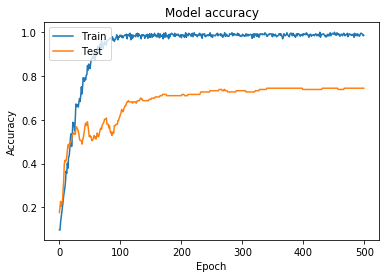

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 3

In [156]:
Train = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 175/175 [00:00<00:00, 501.38it/s]


In [157]:
# Re-initialize weights, since training and testing data switch
AR_single = build_AR_single(C)

In [158]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=500,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 434 samples, validate on 175 samples
Epoch 1/500
434/434 [==============================] - 21s 47ms/step - loss: 3.2937 - acc: 0.0714 - val_loss: 2.6166 - val_acc: 0.1029
Epoch 2/500
434/434 [==============================] - 0s 155us/step - loss: 3.0658 - acc: 0.1106 - val_loss: 2.5618 - val_acc: 0.1943
Epoch 3/500
434/434 [==============================] - 0s 186us/step - loss: 2.7731 - acc: 0.1521 - val_loss: 2.5341 - val_acc: 0.2286
Epoch 4/500
434/434 [==============================] - 0s 158us/step - loss: 2.5868 - acc: 0.1843 - val_loss: 2.5579 - val_acc: 0.2514
Epoch 5/500
434/434 [==============================] - 0s 149us/step - loss: 2.4685 - acc: 0.1889 - val_loss: 2.5653 - val_acc: 0.2743
Epoch 6/500
434/434 [==============================] - 0s 162us/step - loss: 2.4412 - acc: 0.2074 - val_loss: 2.5778 - val_acc: 0.2914
Epoch 7/500
434/434 [==============================] - 0s 167us/step - loss: 2.3097 - acc: 0.2488 - val_loss: 2.5618 - val_acc: 0.3200
Epoch 8/5

Epoch 61/500
434/434 [==============================] - 0s 206us/step - loss: 0.3565 - acc: 0.9171 - val_loss: 1.6118 - val_acc: 0.5429
Epoch 62/500
434/434 [==============================] - 0s 184us/step - loss: 0.2941 - acc: 0.9539 - val_loss: 1.6423 - val_acc: 0.5314
Epoch 63/500
434/434 [==============================] - 0s 194us/step - loss: 0.2841 - acc: 0.9516 - val_loss: 1.7009 - val_acc: 0.5200
Epoch 64/500
434/434 [==============================] - 0s 212us/step - loss: 0.2652 - acc: 0.9493 - val_loss: 1.7225 - val_acc: 0.5257
Epoch 65/500
434/434 [==============================] - 0s 213us/step - loss: 0.2570 - acc: 0.9516 - val_loss: 1.7511 - val_acc: 0.5200
Epoch 66/500
434/434 [==============================] - 0s 189us/step - loss: 0.2406 - acc: 0.9631 - val_loss: 1.7815 - val_acc: 0.5314
Epoch 67/500
434/434 [==============================] - 0s 220us/step - loss: 0.2790 - acc: 0.9470 - val_loss: 1.8806 - val_acc: 0.5143
Epoch 68/500
434/434 [==========================

434/434 [==============================] - 0s 214us/step - loss: 0.0649 - acc: 0.9954 - val_loss: 1.7236 - val_acc: 0.5943
Epoch 122/500
434/434 [==============================] - 0s 220us/step - loss: 0.0784 - acc: 0.9954 - val_loss: 1.7261 - val_acc: 0.5943
Epoch 123/500
434/434 [==============================] - 0s 196us/step - loss: 0.0563 - acc: 0.9977 - val_loss: 1.7184 - val_acc: 0.6000
Epoch 124/500
434/434 [==============================] - 0s 189us/step - loss: 0.0654 - acc: 0.9954 - val_loss: 1.6989 - val_acc: 0.6114
Epoch 125/500
434/434 [==============================] - 0s 208us/step - loss: 0.0781 - acc: 0.9908 - val_loss: 1.6640 - val_acc: 0.6114
Epoch 126/500
434/434 [==============================] - 0s 212us/step - loss: 0.0747 - acc: 0.9908 - val_loss: 1.6168 - val_acc: 0.6457
Epoch 127/500
434/434 [==============================] - 0s 216us/step - loss: 0.0703 - acc: 0.9931 - val_loss: 1.5632 - val_acc: 0.6571
Epoch 128/500
434/434 [==============================] 

Epoch 181/500
434/434 [==============================] - 0s 164us/step - loss: 0.0535 - acc: 0.9954 - val_loss: 1.2691 - val_acc: 0.6914
Epoch 182/500
434/434 [==============================] - 0s 160us/step - loss: 0.0563 - acc: 0.9931 - val_loss: 1.2654 - val_acc: 0.6914
Epoch 183/500
434/434 [==============================] - 0s 184us/step - loss: 0.0504 - acc: 0.9954 - val_loss: 1.2618 - val_acc: 0.6914
Epoch 184/500
434/434 [==============================] - 0s 201us/step - loss: 0.0512 - acc: 0.9977 - val_loss: 1.2578 - val_acc: 0.6914
Epoch 185/500
434/434 [==============================] - 0s 213us/step - loss: 0.0579 - acc: 0.9908 - val_loss: 1.2543 - val_acc: 0.6914
Epoch 186/500
434/434 [==============================] - 0s 231us/step - loss: 0.0550 - acc: 1.0000 - val_loss: 1.2508 - val_acc: 0.6914
Epoch 187/500
434/434 [==============================] - 0s 206us/step - loss: 0.0625 - acc: 0.9908 - val_loss: 1.2464 - val_acc: 0.6914
Epoch 188/500
434/434 [==================

Epoch 241/500
434/434 [==============================] - 0s 217us/step - loss: 0.0423 - acc: 1.0000 - val_loss: 1.1208 - val_acc: 0.7314
Epoch 242/500
434/434 [==============================] - 0s 213us/step - loss: 0.0556 - acc: 0.9931 - val_loss: 1.1193 - val_acc: 0.7314
Epoch 243/500
434/434 [==============================] - 0s 213us/step - loss: 0.0546 - acc: 0.9931 - val_loss: 1.1184 - val_acc: 0.7314
Epoch 244/500
434/434 [==============================] - 0s 220us/step - loss: 0.0545 - acc: 0.9954 - val_loss: 1.1170 - val_acc: 0.7314
Epoch 245/500
434/434 [==============================] - 0s 216us/step - loss: 0.0456 - acc: 0.9908 - val_loss: 1.1153 - val_acc: 0.7314
Epoch 246/500
434/434 [==============================] - 0s 215us/step - loss: 0.0534 - acc: 0.9977 - val_loss: 1.1136 - val_acc: 0.7314
Epoch 247/500
434/434 [==============================] - 0s 207us/step - loss: 0.0592 - acc: 0.9977 - val_loss: 1.1122 - val_acc: 0.7314
Epoch 248/500
434/434 [==================

Epoch 301/500
434/434 [==============================] - 0s 209us/step - loss: 0.0463 - acc: 0.9977 - val_loss: 1.0784 - val_acc: 0.7314
Epoch 302/500
434/434 [==============================] - 0s 202us/step - loss: 0.0511 - acc: 0.9977 - val_loss: 1.0781 - val_acc: 0.7371
Epoch 303/500
434/434 [==============================] - 0s 214us/step - loss: 0.0411 - acc: 0.9977 - val_loss: 1.0782 - val_acc: 0.7371
Epoch 304/500
434/434 [==============================] - 0s 196us/step - loss: 0.0488 - acc: 0.9954 - val_loss: 1.0782 - val_acc: 0.7371
Epoch 305/500
434/434 [==============================] - 0s 180us/step - loss: 0.0543 - acc: 0.9931 - val_loss: 1.0783 - val_acc: 0.7371
Epoch 306/500
434/434 [==============================] - 0s 197us/step - loss: 0.0433 - acc: 0.9977 - val_loss: 1.0783 - val_acc: 0.7371
Epoch 307/500
434/434 [==============================] - 0s 195us/step - loss: 0.0637 - acc: 0.9931 - val_loss: 1.0782 - val_acc: 0.7371
Epoch 308/500
434/434 [==================

Epoch 361/500
434/434 [==============================] - 0s 215us/step - loss: 0.0436 - acc: 0.9954 - val_loss: 1.0669 - val_acc: 0.7486
Epoch 362/500
434/434 [==============================] - 0s 221us/step - loss: 0.0368 - acc: 0.9977 - val_loss: 1.0668 - val_acc: 0.7486
Epoch 363/500
434/434 [==============================] - 0s 224us/step - loss: 0.0552 - acc: 0.9885 - val_loss: 1.0666 - val_acc: 0.7486
Epoch 364/500
434/434 [==============================] - 0s 215us/step - loss: 0.0553 - acc: 0.9977 - val_loss: 1.0663 - val_acc: 0.7486
Epoch 365/500
434/434 [==============================] - 0s 210us/step - loss: 0.0386 - acc: 1.0000 - val_loss: 1.0660 - val_acc: 0.7486
Epoch 366/500
434/434 [==============================] - 0s 199us/step - loss: 0.0476 - acc: 0.9977 - val_loss: 1.0656 - val_acc: 0.7486
Epoch 367/500
434/434 [==============================] - 0s 186us/step - loss: 0.0396 - acc: 1.0000 - val_loss: 1.0653 - val_acc: 0.7486
Epoch 368/500
434/434 [==================

Epoch 421/500
434/434 [==============================] - 0s 214us/step - loss: 0.0482 - acc: 0.9977 - val_loss: 1.0644 - val_acc: 0.7486
Epoch 422/500
434/434 [==============================] - 0s 212us/step - loss: 0.0415 - acc: 0.9977 - val_loss: 1.0644 - val_acc: 0.7486
Epoch 423/500
434/434 [==============================] - 0s 193us/step - loss: 0.0303 - acc: 1.0000 - val_loss: 1.0645 - val_acc: 0.7486
Epoch 424/500
434/434 [==============================] - 0s 210us/step - loss: 0.0425 - acc: 1.0000 - val_loss: 1.0645 - val_acc: 0.7486
Epoch 425/500
434/434 [==============================] - 0s 221us/step - loss: 0.0542 - acc: 0.9908 - val_loss: 1.0643 - val_acc: 0.7486
Epoch 426/500
434/434 [==============================] - 0s 214us/step - loss: 0.0579 - acc: 0.9931 - val_loss: 1.0644 - val_acc: 0.7486
Epoch 427/500
434/434 [==============================] - 0s 172us/step - loss: 0.0421 - acc: 0.9977 - val_loss: 1.0644 - val_acc: 0.7486
Epoch 428/500
434/434 [==================

Epoch 481/500
434/434 [==============================] - 0s 215us/step - loss: 0.0494 - acc: 0.9977 - val_loss: 1.0581 - val_acc: 0.7543
Epoch 482/500
434/434 [==============================] - 0s 192us/step - loss: 0.0473 - acc: 0.9954 - val_loss: 1.0581 - val_acc: 0.7543
Epoch 483/500
434/434 [==============================] - 0s 182us/step - loss: 0.0428 - acc: 0.9954 - val_loss: 1.0581 - val_acc: 0.7543
Epoch 484/500
434/434 [==============================] - 0s 176us/step - loss: 0.0407 - acc: 1.0000 - val_loss: 1.0584 - val_acc: 0.7543
Epoch 485/500
434/434 [==============================] - 0s 203us/step - loss: 0.0524 - acc: 0.9954 - val_loss: 1.0583 - val_acc: 0.7543
Epoch 486/500
434/434 [==============================] - 0s 191us/step - loss: 0.0457 - acc: 0.9977 - val_loss: 1.0583 - val_acc: 0.7543
Epoch 487/500
434/434 [==============================] - 0s 183us/step - loss: 0.0491 - acc: 0.9954 - val_loss: 1.0583 - val_acc: 0.7486
Epoch 488/500
434/434 [==================

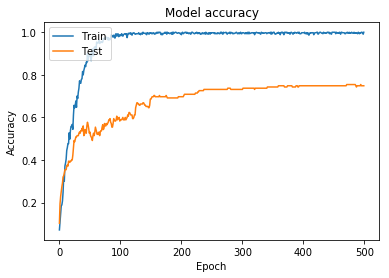

In [159]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
(0.7784+0.7443+0.7543)/3

0.759